In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import spacy
import pickle
from gensim.sklearn_api import D2VTransformer
from joblib import dump, load
import re
import sys

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
dataset = pd.read_csv('dataset/tweets_dataset/financial_tweets.csv', encoding='utf8')

In [3]:
dataset.head()

,sentiment,title
0,0,Are YOU burning more cash $$$ than Chrysler an...
1,0,Tell me again why we are giving more $$ to GM?...
2,0,F*ck Time Warner Cable!!! You f*cking suck bal...
3,0,OMG - time warner f'ed up my internet install ...
4,0,pissed about at&amp;t's mid-contract upgrade p...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9144 entries, 0 to 9143
Data columns (total 2 columns):
sentiment    9144 non-null int64
title        9144 non-null object
dtypes: int64(1), object(1)
memory usage: 143.0+ KB


In [5]:
dataset.describe()

,sentiment
count,9144.000000
mean,0.421916
std,0.493892
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
nb_pos, nb_neg = len([sent for sent in dataset.sentiment if sent == 1]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 9144
Number of positive data : 3858 (42.192%)
Number of negative data : 5286 (57.808%)
Ratio positive/negative : 0.73


In [7]:
def average_word_by_sentence(sentences):
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [8]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 17.975


Text(0, 0.5, 'Number of sentence')

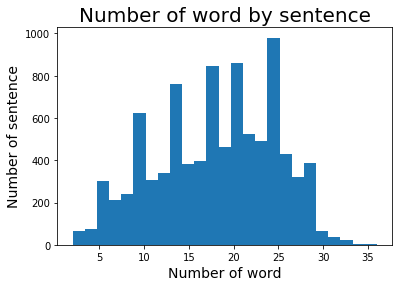

In [9]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

In [3]:
X = dataset['title']
y = dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [4]:
nlp = spacy.load('en')
class TextProcessor(BaseEstimator, TransformerMixin):
    '''Class use in pipeline to processing the text'''
    def __init__(self, remove_stop_word=False, keep_only_good_word=True, min_word_size=2, is_word_joined=True):
        '''Constructor of TextProcessor
        
        remove_stop_word=False -- remove stop word in the sentence
        keep_only_good_word=True -- keep only the verb, adverb, noun and adjectiv otherwise keep all the word type
        min_word_size=2 -- remove all the word smaller that min_word_size, -1 to ignore this param
        '''
        self.remove_stop_word = remove_stop_word
        self.keep_only_good_word = keep_only_good_word
        self.min_word_size = min_word_size
        self.good_words = ['VERB', 'ADV', 'NOUN', 'ADJ', 'NUM']
        self.is_word_joined = is_word_joined
        
        self.punctuations = string.punctuation
        
    def spacy_text_processing(self, sentence):
        '''Process the sentence, Cut the sentence in word, according to the parameters : deletes the stop word, 
        keeps only or not the verbs, adjectives, noun and adverb, deletes the words below a certain size, 
        removes the punctuation, and keeps only the roots of the word.
        
        sentence -- sentence to transform
        '''
        final_sentence = []
        for word in nlp(sentence):
            if self.remove_stop_word:
                if word.is_stop:
                    continue
                    
            if self.keep_only_good_word:
                if word.pos_ not in self.good_words:
                    continue
                    
            if self.min_word_size!=-1:
                if len(word.text) < self.min_word_size:
                    continue
                    
            if word.text not in self.punctuations:
                final_sentence.append(word.lemma_)
        final_sentence = ' '.join(final_sentence)
        final_sentence = re.sub(r'@\S*', 'TWITTER_USER', final_sentence)
        final_sentence = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', final_sentence)
        return final_sentence
        
    def transform(self, X, y=None):
        '''Transform the text, call by the pipeline
        
        X -- data
        y=None -- labels of the data
        '''
        X_transformed = []
        for sentence in X:
            if self.is_word_joined:
                X_transformed.append(self.spacy_text_processing(sentence))
            else : 
                X_transformed.append(self.spacy_text_processing(sentence).split(' '))
        return X_transformed
    
    def fit(self, X, y=None):
        '''Use for estimation
        
        X -- data
        y=None -- labels of the data
        '''
        return self

In [5]:
tp = TextProcessor(min_word_size=-1, remove_stop_word=True)
X_train_pre = tp.transform(X_train)
X_test_pre = tp.transform(X_test)

In [7]:
nb_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC())])

dtc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('dtc', DecisionTreeClassifier())])

lr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

nb_model.fit(X_train_pre, y_train)
svc_model.fit(X_train_pre, y_train)
dtc_model.fit(X_train_pre, y_train)
lr_model.fit(X_train_pre, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [8]:
y_pred_nb = nb_model.predict(X_test_pre)
print("Accuracy for Naive Bayes : {}".format(metrics.accuracy_score(y_test, y_pred_nb)))
y_pred_svc = svc_model.predict(X_test_pre)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test, y_pred_svc)))
y_pred_dtc = dtc_model.predict(X_test_pre)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test, y_pred_dtc)))
y_pred_lr = lr_model.predict(X_test_pre)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test, y_pred_lr)))

Accuracy for Naive Bayes : 0.6544559868780755
Accuracy for SVC : 0.5833788955713505
Accuracy for Decision Tree Classifier : 0.6096227446692182
Accuracy for Logistic Regression : 0.6686714051394205


# Sauvegarde du modèle

In [9]:
dump(lr_model, 'saved_model/tweets_dataset_tfid.joblib')

['saved_model/tweets_dataset_tfid.joblib']

# Word2vec

In [10]:
tp_d2v = TextProcessor(is_word_joined=False)
X_train_pre_list = tp_d2v.transform(X_train)
X_test_pre_list = tp_d2v.transform(X_test)

In [12]:
doc2Vec_model =  D2VTransformer()
doc2Vec_model.fit(X_train_pre_list)

D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1, comment=None,
               dbow_words=0, dm=1, dm_concat=0, dm_mean=None, dm_tag_count=1,
               docvecs=None, docvecs_mapfile=None,
               hashfxn=<built-in function hash>, hs=0, iter=5,
               max_vocab_size=None, min_alpha=0.0001, min_count=5, negative=5,
               sample=0.001, seed=1, size=100, sorted_vocab=1, trim_rule=None,
               window=5, workers=3)

In [13]:
svc_model_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('svc', SVC())])

dtc_model_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('dtc', DecisionTreeClassifier())])

lr_model_d2v = Pipeline([('d2v', doc2Vec_model),
                    ('lr', LogisticRegression())])

svc_model_d2v.fit(X_train_pre_list, y_train)
dtc_model_d2v.fit(X_train_pre_list, y_train)
lr_model_d2v.fit(X_train_pre_list, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('d2v',
                 D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1,
                                comment=None, dbow_words=0, dm=1, dm_concat=0,
                                dm_mean=None, dm_tag_count=1, docvecs=None,
                                docvecs_mapfile=None,
                                hashfxn=<built-in function hash>, hs=0, iter=5,
                                max_vocab_size=None, min_alpha=0.0001,
                                min_count=5, negative=5, sample=0.001, seed=1,
                                size=100, sorted_vocab=1, trim_rule=None,
                                window=5, workers=3)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
 

In [14]:
y_pred_svc_d2v = svc_model_d2v.predict(X_test_pre_list)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test, y_pred_svc_d2v)))
y_pred_dtc_d2v = dtc_model_d2v.predict(X_test_pre_list)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test, y_pred_dtc_d2v)))
y_pred_lr_d2v = lr_model_d2v.predict(X_test_pre_list)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test, y_pred_lr_d2v)))

Accuracy for SVC : 0.5833788955713505
Accuracy for Decision Tree Classifier : 0.4931656642974303
Accuracy for Logistic Regression : 0.5833788955713505


# Sauvegarde du modèle

In [15]:
dump(lr_model_d2v, 'saved_model/tweets_dataset_w2v.joblib')

['saved_model/tweets_dataset_w2v.joblib']

In [8]:
sys.path.insert(0, 'Word2Vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('C:/Users/romain.capocasa/financialsentiments/Word2Vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
w2vec_model = financial_w2vec.model
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romain.capocasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
max_sentence_length = 0
for sentence in dataset["title"]:
    sentence_length = len(sentence.split())
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
print("The maximum word in a sentence is : {}".format(max_sentence_length))

The maximum word in a sentence is : 36


In [10]:
def sentences_to_w2v(sentences):
    sentences_w2v = []
    for sentence in sentences:      
        vectors = np.zeros(100)
        
        for word in sentence.split():
            if word in w2vec_model.wv.vocab: 
                doc = trigram_mod[bigram_mod[[word]]]
                vectors = np.add(vectors, w2vec_model.wv[doc][0])
        sentences_w2v.append(vectors)
    return np.asarray(sentences_w2v)

In [11]:
X_train_pre_w2v = sentences_to_w2v(X_train_pre)
X_test_pre_w2v = sentences_to_w2v(X_test_pre)

In [13]:
svc_model_w2v = SVC()
svc_model_w2v.fit(X_train_pre_w2v, y_train)

dtc_model_w2v = DecisionTreeClassifier()
dtc_model_w2v.fit(X_train_pre_w2v, y_train)

lr_model_w2v = LogisticRegression()
lr_model_w2v.fit(X_train_pre_w2v, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
y_pred_svc_w2v = svc_model_w2v.predict(X_test_pre_w2v)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test, y_pred_svc_w2v)))
y_pred_dtc_w2v = dtc_model_w2v.predict(X_test_pre_w2v)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test, y_pred_dtc_w2v)))
y_pred_lr_w2v = lr_model_w2v.predict(X_test_pre_w2v)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test, y_pred_lr_w2v)))

Accuracy for SVC : 0.5975943138326955
Accuracy for Decision Tree Classifier : 0.5522143247676325
Accuracy for Logistic Regression : 0.6260251503553854
